# Loading MJCF models from file(s), then

# Basic rendering, simulation, and animation

In order to render we'll need to instantiate a `Renderer` object and call its `render` method.

We'll also reload our model to make the colab's sections independent.

""

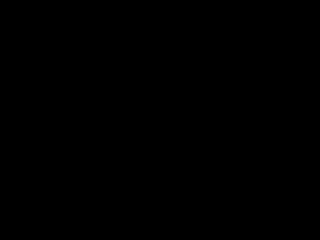

""

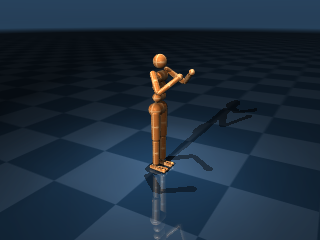

In [2]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt

import time
import itertools
import numpy as np

#model = mujoco.MjModel.from_xml_string(xml)
#model = mujoco.MjModel.from_xml_path(r"C:\Users\wenbin.li\Documents\GitHub\MuJoCo-Tutorial-fork\example_models\robotiq_2f85\scene.xml")
#model = mujoco.MjModel.from_xml_path(r"C:\Users\wenbin.li\Documents\GitHub\MuJoCo-Tutorial-fork\example_models\robotiq_2f85\2f85.xml")
model = mujoco.MjModel.from_xml_path(r"C:\Users\wenbin.li\Documents\GitHub\MuJoCo-Tutorial-fork\xml\humanoid.xml")
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)
media.show_image(renderer.render())

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

Hmmm, why the black pixels?

**Answer:** For the same reason as above, we first need to propagate the values in `mjData`. This time we'll call [`mj_forward`](https://mujoco.readthedocs.io/en/latest/APIreference.html#mj-forward), which invokes the entire pipeline up to the computation of accelerations i.e., it computes $\dot x = f(x)$, where $x$ is the state. This function does more than we actually need, but unless we care about saving computation time, it's good practice to call `mj_forward` since then we know we are not missing anything.

We also need to update the `mjvScene` which is an object held by the renderer describing the visual scene. We'll later see that the scene can include visual objects which are not part of the physical model.

## mjModel

MuJoCo's `mjModel`, contains the *model description*, i.e., all quantities which *do not change over time*. The complete description of `mjModel` can be found at the end of the header file [`mjmodel.h`](https://github.com/deepmind/mujoco/blob/main/include/mujoco/mjmodel.h). Note that the header files contain short, useful inline comments, describing each field.

Examples of quantities that can be found in `mjModel` are `ngeom`, the number of geoms in the scene and `geom_rgba`, their respective colors:

In [3]:
model.ngeom

20

In [4]:
model.geom_rgba

array([[0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ]], dtype=float32)

## Named access

The MuJoCo Python bindings provide convenient [accessors](https://mujoco.readthedocs.io/en/latest/python.html#named-access) using names. Calling the `model.geom()` accessor without a name string generates a convenient error that tells us what the valid names are.

In [5]:
try:
  model.geom()
except KeyError as e:
  print(e)

"Invalid name ''. Valid names: ['butt', 'floor', 'foot1_left', 'foot1_right', 'foot2_left', 'foot2_right', 'hand_left', 'hand_right', 'head', 'lower_arm_left', 'lower_arm_right', 'shin_left', 'shin_right', 'thigh_left', 'thigh_right', 'torso', 'upper_arm_left', 'upper_arm_right', 'waist_lower', 'waist_upper']"


Calling the named accessor without specifying a property will tell us what all the valid properties are:

Note that the 0th body is always the `world`. It cannot be renamed.

The `id` and `name` attributes are useful in Python comprehensions:

In [7]:
[model.geom(i).name for i in range(model.ngeom)]

['floor',
 'torso',
 'waist_upper',
 'head',
 'waist_lower',
 'butt',
 'thigh_right',
 'shin_right',
 'foot1_right',
 'foot2_right',
 'thigh_left',
 'shin_left',
 'foot1_left',
 'foot2_left',
 'upper_arm_right',
 'lower_arm_right',
 'hand_right',
 'upper_arm_left',
 'lower_arm_left',
 'hand_left']

## `mjData`
`mjData` contains the *state* and quantities that depend on it. The state is made up of time, [generalized](https://en.wikipedia.org/wiki/Generalized_coordinates) positions and generalized velocities. These are respectively `data.time`, `data.qpos` and `data.qvel`. In order to make a new `mjData`, all we need is our `mjModel`

In [11]:
data = mujoco.MjData(model)

`mjData` also contains *functions of the state*, for example the Cartesian positions of objects in the world frame. The (x, y, z) positions of our two geoms are in `data.geom_xpos`:

In [12]:
print(data.geom_xpos)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


Wait, why are both of our geoms at the origin? Didn't we offset the green sphere? The answer is that derived quantities in `mjData` need to be explicitly propagated (see [below](#scrollTo=QY1gpms1HXeN)). In our case, the minimal required function is [`mj_kinematics`](https://mujoco.readthedocs.io/en/latest/APIreference.html#mj-kinematics), which computes global Cartesian poses for all objects (excluding cameras and lights).

In [13]:
mujoco.mj_kinematics(model, data)
print('raw access:\n', data.geom_xpos)

# MjData also supports named access:
print('\nnamed access:\n', data.geom('left_pad1').xpos)

raw access:
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.60583591e-04  8.53627524e-05  6.94080063e-03]
 [-3.60583591e-04  8.53627524e-05  6.94080063e-03]
 [-2.70393921e-05 -9.19702617e-08  4.62674813e-02]
 [-2.70393921e-05 -9.19702617e-08  4.62674813e-02]
 [ 4.83557933e-02 -2.96930954e-12  6.67771416e-02]
 [ 4.83557933e-02 -2.96930954e-12  6.67771416e-02]
 [ 6.51131854e-02 -8.45804230e-13  8.48215383e-02]
 [ 6.51131854e-02 -8.45804230e-13  8.48215383e-02]
 [ 3.13623998e-02  8.65005011e-09  9.29658099e-02]
 [ 3.13623998e-02  8.65005011e-09  9.29658099e-02]
 [ 5.71540352e-02  8.22250567e-08  1.21678641e-01]
 [ 5.71540352e-02  8.22250567e-08  1.21678641e-01]
 [ 4.67000000e-02  0.00000000e+00  1.50845000e-01]
 [ 4.67000000e-02  0.00000000e+00  1.32095000e-01]
 [ 4.68000001e-02 -1.92787321e-14  1.41237376e-01]
 [ 4.35000001e-02 -1.92790101e-14  1.41237376e-01]
 [-4.83557933e-02  2.96930954e-12  6.67771416e-02]
 [-4.83557933e-02  2.96930954e-12  6.67771416e-02]
 [-6.51131854e-02 